<a href="https://colab.research.google.com/github/bpmasters/asa-challenge-24/blob/main/asa-challenge-24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import librosa
import scipy
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')
# drive.download('/content/drive/ASA-Challenge-24/HYD1.wav')
# drive.download('ASA-Challenge-24/HYD2.wav')
# drive.download('ASA-Challenge-24/HYD3.wav')
plt.rcParams['figure.figsize'] = (20, 10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# copy of matlab buffer function
def buffer(signal, frame_size, overlap_size=0):
    step_size = frame_size - overlap_size
    total_frames = int(np.ceil(len(signal) / step_size))

    padded_length = total_frames * step_size + overlap_size
    padded_signal = np.append(signal, np.zeros(padded_length - len(signal)))

    frames = np.lib.stride_tricks.sliding_window_view(padded_signal, frame_size)[::step_size]

    return frames

In [7]:
# import data and normalize to -1:1
fs, h1 = scipy.io.wavfile.read('/content/drive/MyDrive/ASA-Challenge-24/HYD1.wav')
_,  h2 = scipy.io.wavfile.read('/content/drive/MyDrive/ASA-Challenge-24/HYD2.wav')
_,  h3 = scipy.io.wavfile.read('/content/drive/MyDrive/ASA-Challenge-24/HYD3.wav')

h1 = h1.astype(np.float32)/np.iinfo(h1.dtype).max
h2 = h2.astype(np.float32)/np.iinfo(h2.dtype).max
h3 = h3.astype(np.float32)/np.iinfo(h3.dtype).max

ts = np.arange(0, len(h1)/fs, 1/fs)

Text(0, 0.5, 'FFT Coefficient [dBFS]')

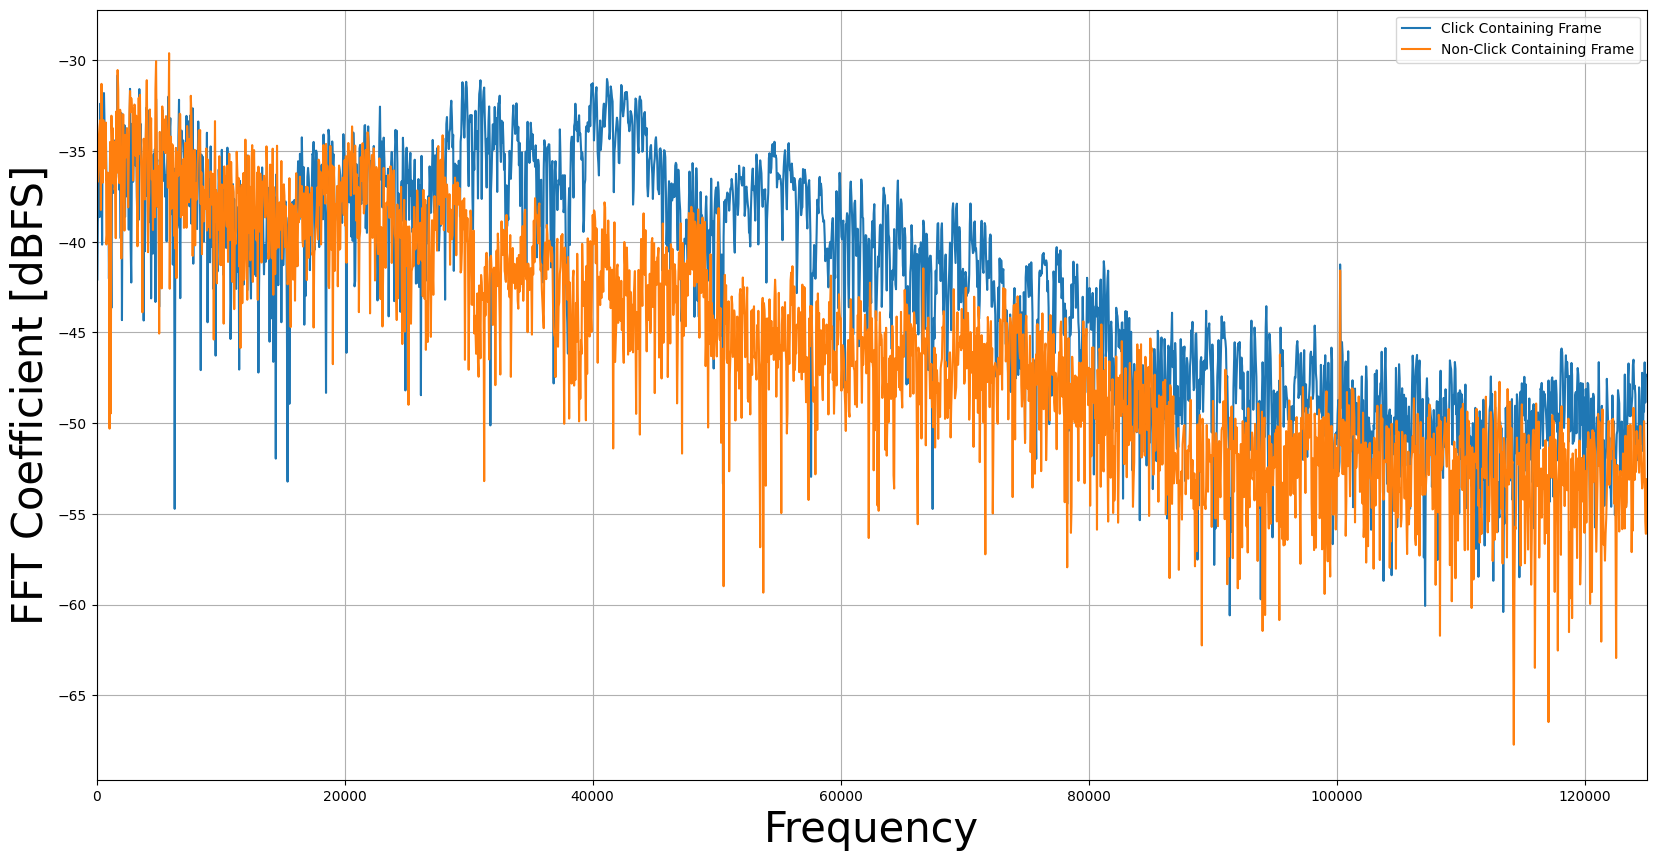

In [169]:
# Plot spectra of hydrophone data during a click and not a click
N = len(h1[int(2.2*fs):int(2.22*fs)])
T = 1/fs
yf = scipy.fftpack.fft(h1[int(2.2*fs):int(2.22*fs)])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots(figsize = (20,10))
ax.plot(xf, 10*np.log10(2.0/N * np.abs(yf[:N//2])), label = 'Click Containing Frame')
plt.xlim(0,125e3)
N = len(h1[int(2.5*fs):int(2.52*fs)])
T = 1/fs
yf = scipy.fftpack.fft(h1[int(2.5*fs):int(2.52*fs)])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
ax.plot(xf, 10*np.log10(2.0/N * np.abs(yf[:N//2])), label = 'Non-Click Containing Frame')
plt.legend()
plt.grid()
plt.xlabel('Frequency', fontsize = 30)
plt.ylabel('FFT Coefficient [dBFS]', fontsize = 30)

In [170]:
# Develop a bandpass filter based on spectral observations
bpf_l = 25000
bpf_h = 75000
bpf_N = 20

# Can verify here using transfer function type filter
# [bpf_b, bpf_a] = scipy.signal.butter(bpf_N, [bpf_l, bpf_h], btype='bandpass', fs = fs)
# w, h = scipy.signal.freqz(bpf_b, bpf_a)
# plt.semilogx(w*fs/2/np.pi, 20 * np.log10(abs(h)))

# Implement operation using second order sections for minimal numerical errors
bpf_sos = scipy.signal.butter(bpf_N, [bpf_l, bpf_h], btype='bandpass', fs = fs, output='sos')
h1b = scipy.signal.sosfilt(bpf_sos, h1)
h2b = scipy.signal.sosfilt(bpf_sos, h2)
h3b = scipy.signal.sosfilt(bpf_sos, h3)

In [391]:
# Analysis Parameters for Simple Click Detection
win_size = 128
noverlap = 0 #np.int(np.ceil(win_size/10)) Use no overlap here for minimal uncertainty

# Buffer a time signal
ts_buff = buffer(ts, win_size, noverlap)
ts_buff = ts_buff[:,0]

# Buffer the bandpass filtered middle hydrophone signal
h2_buff = buffer(h2b, win_size, noverlap)
h2_buff_pow = 20*np.log10(np.sqrt(np.mean(h2_buff**2,axis=1)))

# Specify parameters for click detection
dB_peak_thresh_a = 20  # Dolphin A threshold
dB_peak_thresh_b = 17  # Dolphin B threshold
pk_distance = 1  # Distance between peaks, frames
pk_wlen = 50  # Samples to look around the peak
click_cutoff_t = 4.5  # Cutoff time for dolphin A vs. B

# Run prominence based peak detector to find envelope (clicks)
h2_peaks_a, _ = scipy.signal.find_peaks(h2_buff_pow[ts_buff<4.5], prominence=dB_peak_thresh_a, distance=pk_distance, wlen=pk_wlen)
h2_peaks_b, _ = scipy.signal.find_peaks(h2_buff_pow[ts_buff>=4.5], prominence=dB_peak_thresh_b, distance=pk_distance, wlen=pk_wlen)

Text(0.5, 1.0, 'Locations of Detected Clicks, Uncertainty = $\\pm$0.256 ms')

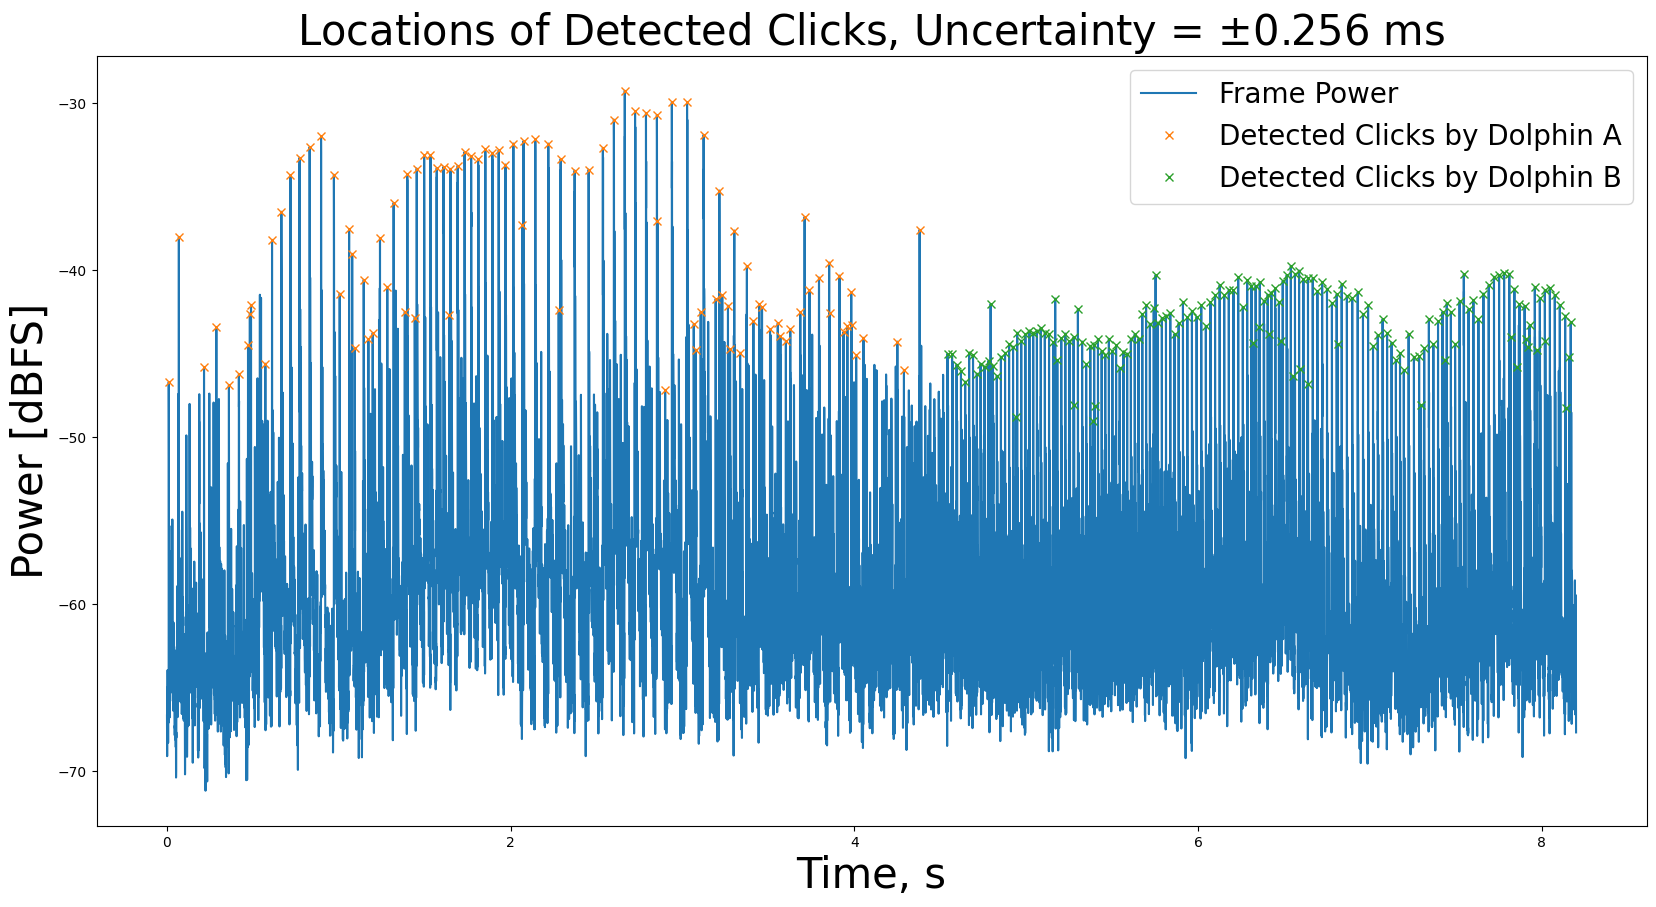

In [392]:
# Plot the frame by frame power along with the detected click locations
plt.figure()
plt.plot(ts_buff, h2_buff_pow, label='Frame Power')
plt.plot(ts_buff[h2_peaks_a], h2_buff_pow[h2_peaks_a], 'x', label='Detected Clicks by Dolphin A')
plt.plot(ts_buff[ts_buff>=4.5][h2_peaks_b], h2_buff_pow[ts_buff>=4.5][h2_peaks_b], 'x', label='Detected Clicks by Dolphin B')
plt.xlabel('Time, s', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend(fontsize=20)
plt.title(r'Locations of Detected Clicks, Uncertainty = $\pm$' + str(np.round(1000*win_size/fs/2, 3)) + ' ms', fontsize=30)


In [393]:
click_cutoff = 4.5/(len(h2)/fs)

ts_buff_a = ts_buff[0:np.int16(np.floor(click_cutoff*len(ts_buff)))]
h2_buff_pow_a = h2_buff_pow[0:np.int16(np.floor(click_cutoff*len(h2_buff_pow)))]
h2_clicks_a = h2_buff_pow[h2_peaks_a]
h2_click_ts_a = ts_buff[h2_peaks_a]

ts_buff_b = ts_buff[np.int16(np.ceil(click_cutoff*len(ts_buff))):]
h2_buff_pow_b = h2_buff_pow[np.int16(np.ceil(click_cutoff*len(h2_buff_pow))):]
h2_clicks_b = h2_buff_pow[h2_peaks_b]
h2_click_ts_b = ts_buff[h2_peaks_b]

# plt.figure()
# plt.stem(h2_click_ts_a, h2_clicks_a, bottom=-55, basefmt='None')
# plt.stem(h2_click_ts_b, h2_clicks_b, bottom=-55, linefmt='orange', basefmt='None')
# plt.legend(['Dolphin A', 'Dolphin B'], fontsize=30)
# plt.xlabel('Time, s', fontsize=30)
# plt.ylabel('Power, dBFS', fontsize=30)
# plt.title('Power of identified clicks by dolphin', fontsize=30)


Text(0.5, 1.0, 'Inter-click Interval by Click\nTotal Number of Clicks: A: 99 B: 167\nMean Inter-Click Interval: A: 44.0 B: 22.0\nStandard Deviation of Inter-Click Interval: A: 28.0 B: 7.15')

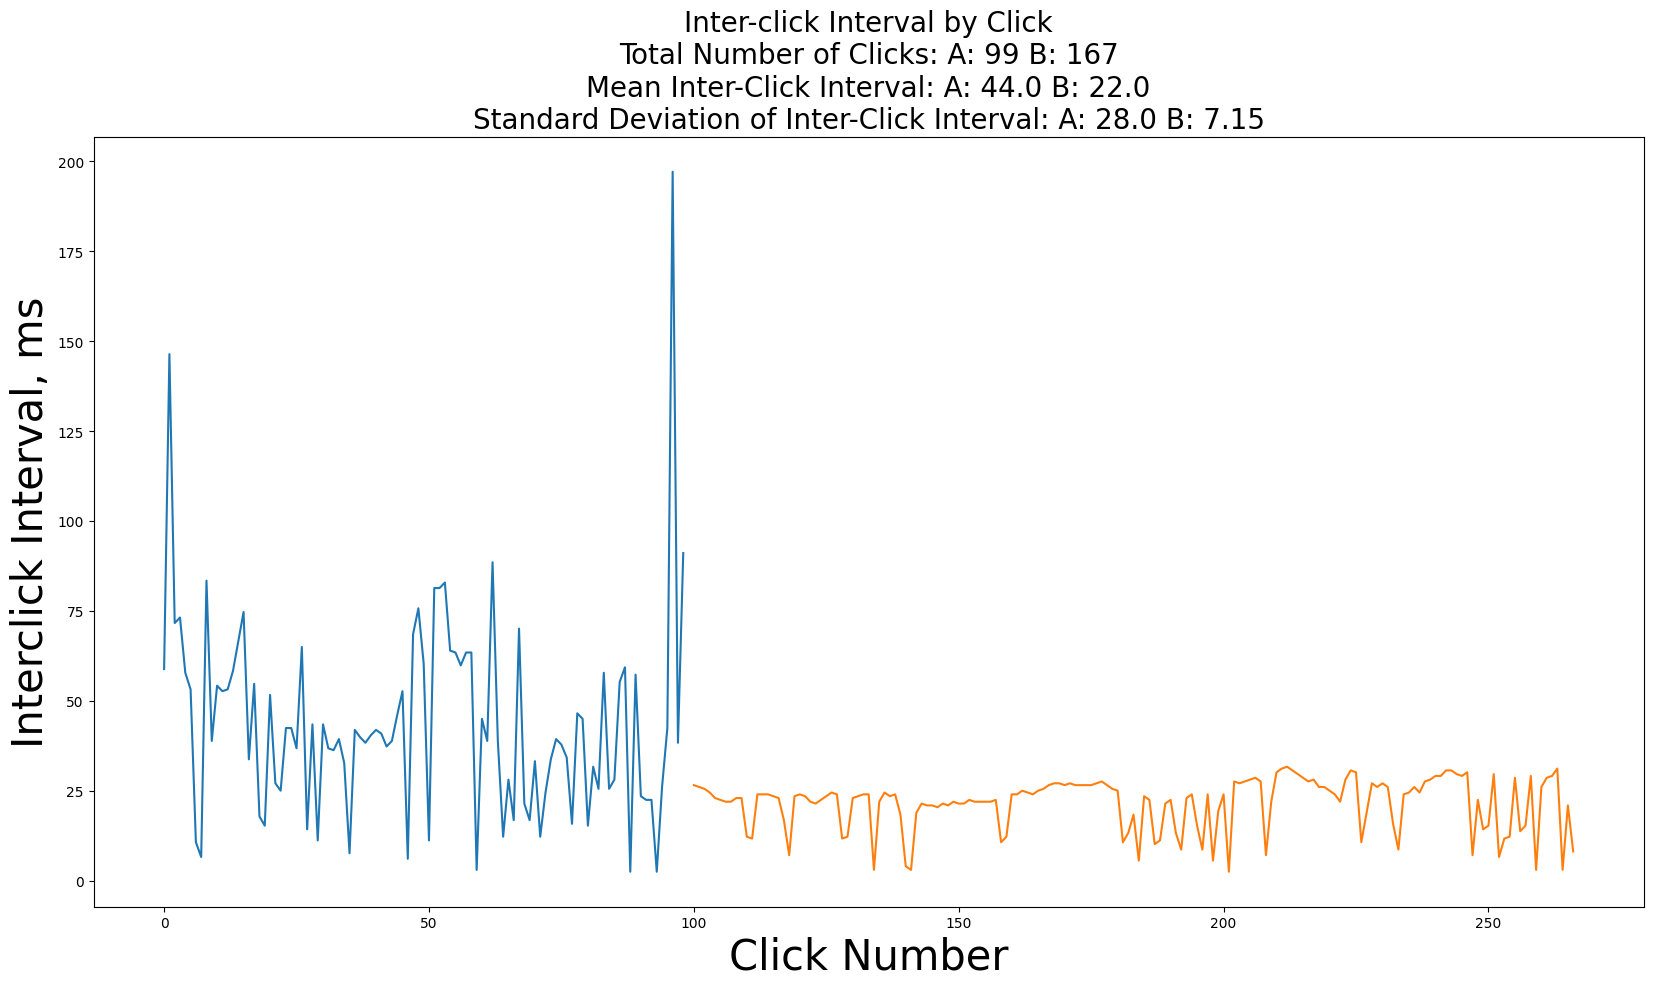

In [394]:
# Plotting the interclick interval by click number, along with some statistics
ici_a = np.diff(h2_click_ts_a)*1000
ici_b = np.diff(h2_click_ts_b)*1000

plt.figure()
plt.plot(np.arange(0,len(ici_a)), ici_a, label='Dolphin A')
plt.plot(np.arange(len(ici_a)+1,len(ici_b)+len(ici_a)+1), ici_b, label='Dolphin B')
plt.ylabel('Interclick Interval, ms', fontsize = 30)
plt.xlabel('Click Number', fontsize = 30)
plt.title('Inter-click Interval by Click' + '\n' + 'Total Number of Clicks: ' + 'A: ' + str(len(ici_a)) + ' B: ' + str(len(ici_b)) + '\n'
          + 'Mean Inter-Click Interval: A: ' + str(np.round(np.mean(ici_a))) + ' B: ' + str(np.round(np.mean(ici_b))) + '\n'
          + 'Standard Deviation of Inter-Click Interval: A: ' + str(np.round(np.std(ici_a))) + ' B: ' + str(np.round(np.std(ici_b),2)), fontsize = 20)

##TASK 2

In [622]:
d = 14  # meters, separating hydrophones
c = 1520  # m/s, speed of sound in water
max_td = d/c

win_size = 4096
noverlap = int(np.ceil(win_size*.99))

dB_peak_thresh_a = 18
dB_peak_thresh_b = 15
pk_distance = 5
click_cutoff = int(4.5 * fs)

In [623]:
def gccphat(x, y):
    n = (x.shape[0]+y.shape[0])
    max_shift = int(n/2)
    X = np.fft.rfft(x)
    Y = np.fft.rfft(y)
    R = X*np.conj(Y)

    cc = np.fft.irfft(R/np.abs(R))
    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))


    tau = np.argmax(np.abs(cc)) - max_shift

    return tau/fs, cc

def band_energy(fs, y):
    # bandpass regions
    f_l_target = 25000
    f_h_target = 75000

    # FFT size
    n = y.shape[0]

    # FFT frequency bins
    freqs = np.fft.fftfreq(n, 1/fs)
    freqs = freqs[:n//2]

    # FFT output
    Y = np.abs(np.fft.fft(y)) / n
    Y = Y[:n//2]
    Y[1:] = 2*Y[1:]

    f_l = np.argmin(np.abs(freqs-f_l_target))
    f_h = np.argmin(np.abs(freqs-f_h_target))

    # energy = 10*np.log10(np.sum(np.abs(Y[f_l:f_h]**2)))
    energy = 20*np.log10(np.sqrt(np.mean(Y**2)))

    return energy


### Dolphin A

In [624]:
# Dolphin A
h1_a = h1[:click_cutoff]
h2_a = h2[:click_cutoff]
h3_a = h3[:click_cutoff]

# Segment/buffer signals
h1_buff = buffer(h1_a, win_size, noverlap)
h2_buff = buffer(h2_a, win_size, noverlap)
h3_buff = buffer(h3_a, win_size, noverlap)

h1_powers = []
h2_powers = []
h3_powers = []

h12_powers = []
h13_powers = []
h23_powers = []

delays_12 = []
delays_13 = []
delays_23 = []

good_frame_delays_12 = []
good_frame_delays_13 = []
good_frame_delays_23 = []

dBThresh = -48

for i, (b1, b2, b3) in enumerate(zip(h1_buff, h2_buff, h3_buff)):
    h1_powers.append(20*np.log10(np.sqrt(np.mean(b1**2))))
    h2_powers.append(20*np.log10(np.sqrt(np.mean(b2**2))))
    h3_powers.append(20*np.log10(np.sqrt(np.mean(b3**2))))

    lag_12, cc_12 = gccphat(b1, b2)
    lag_13, cc_13 = gccphat(b1, b3)
    lag_23, cc_23 = gccphat(b2, b3)

    delays_12.append(lag_12)
    delays_13.append(lag_13)
    delays_23.append(lag_23)

    b12 = (b1+b2)/2
    b13 = (b1+b3)/2
    b23 = (b2+b3)/2

    e12 = 20*np.log10(np.sqrt(np.mean(b12**2)))
    e13 = 20*np.log10(np.sqrt(np.mean(b13**2)))
    e23 = 20*np.log10(np.sqrt(np.mean(b23**2)))
    # e12 = band_energy(fs, b12)
    # e13 = band_energy(fs, b13)
    # e23 = band_energy(fs, b23)

    h12_powers.append(e12)
    h13_powers.append(e13)
    h23_powers.append(e23)

    # if e12 > dBThresh:
    #     good_frame_delays_12.append(lag_12)
    # else:
    #     good_frame_delays_12.append(np.nan)

    # if e13 > dBThresh:
    #     good_frame_delays_13.append(lag_13)
    # else:
    #     good_frame_delays_13.append(np.nan)

    # if e23 > dBThresh:
    #     good_frame_delays_23.append(lag_23)
    # else:
    #     good_frame_delays_23.append(np.nan)

dB_peak_thresh_a = 1  # Dolphin A threshold
pk_distance = 1  # Distance between peaks, frames
pk_wlen = 100  # Samples to look around the peak
good_frame_inds_12, _ = scipy.signal.find_peaks(np.array(h12_powers), prominence=dB_peak_thresh_a, distance=pk_distance, wlen=pk_wlen)
good_frame_delays_12 = np.array(delays_12)[good_frame_inds_12]

good_frame_inds_13, _ = scipy.signal.find_peaks(np.array(h13_powers), prominence=dB_peak_thresh_a, distance=pk_distance, wlen=pk_wlen)
good_frame_delays_13 = np.array(delays_13)[good_frame_inds_13]

good_frame_inds_23, _ = scipy.signal.find_peaks(np.array(h23_powers), prominence=dB_peak_thresh_a, distance=pk_distance, wlen=pk_wlen)
good_frame_delays_23 = np.array(delays_23)[good_frame_inds_23]





<ipython-input-623-b1e382a3f10d>:8: RuntimeWarning: invalid value encountered in divide
  cc = np.fft.irfft(R/np.abs(R))


In [625]:
print(good_frame_inds_12)
print(good_frame_inds_13)
print(good_frame_inds_23)

[ 1607  4112  7323  8240  8648  9011  9313 10261 10527 10989 11245 11527
 11987 12241 12534 14243 17372 19439 20032 24605]
[ 7711  8684  9034  9535  9934 10011 10258 10527 10616 10702 10775 11017
 11101 11268 11532 11784 12020 12264 12549 12885 12919 13348 13824 14268
 14780 15288 15808 15900 16207 16605 16980 17376 17772 18317 18870 19401
 19472 20040 20131 22201 23603 24034 24349 24561 24615 27330]
[ 4139  4821  7318  7711  8646  8726  9009  9582 10026 10573 10621 10783
 11162 11243 11570 12442 12576 12921 13388 13441 16650 17001 18111 18880
 19486 20607 21060 24428 24561]


58.0
28
23
17


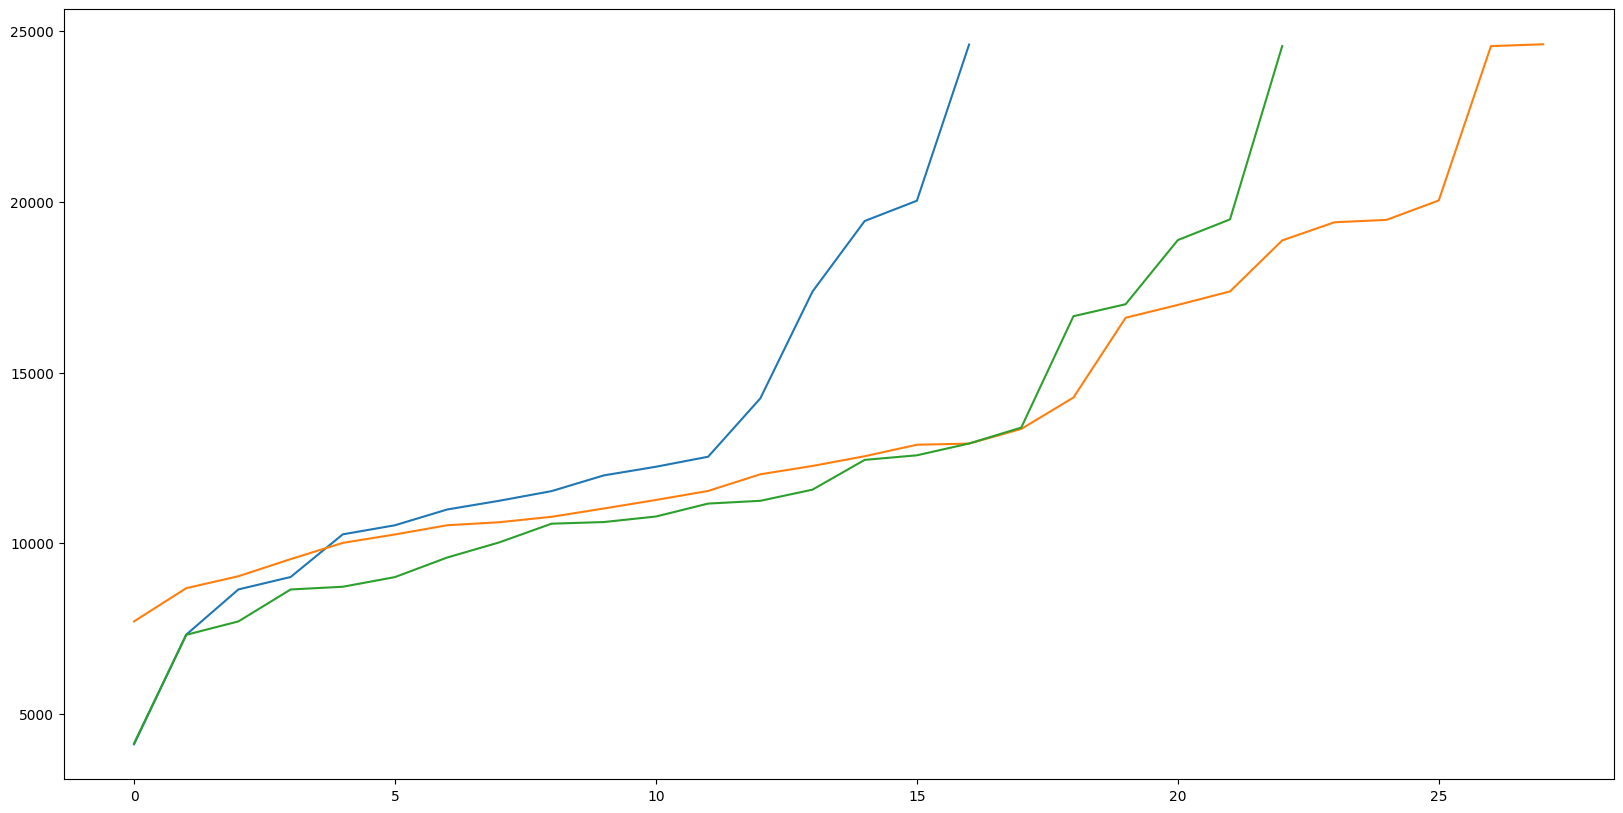

In [626]:
# Associate clicks across permutations of hydrophone pairs by removing unique high power frames

max_dist = np.ceil(max_td / ((win_size - noverlap) / fs))  # 7 m to either side, will need to be doubled for far comparison
print(max_dist)

mask_13 = np.zeros(len(good_frame_inds_13), dtype=bool)
mask_12 = np.zeros(len(good_frame_inds_12), dtype=bool)
mask_23 = np.zeros(len(good_frame_inds_23), dtype=bool)

for i, i_13 in enumerate(good_frame_inds_13):
  # if not (np.abs(good_frame_inds_12 - i_13) < max_dist).any() or not (np.abs(good_frame_inds_23 - i_13) < max_dist).any():
  #   good_frame_inds_13 = good_frame_inds_13[good_frame_inds_13 != i_13]
  mask_13[i] = (np.abs(good_frame_inds_12 - i_13) < max_dist).any() or \
                 (np.abs(good_frame_inds_23 - i_13) < max_dist).any()

for i, i_12 in enumerate(good_frame_inds_12):
  # if not (np.abs(good_frame_inds_13 - i_12) < max_dist).any() or not (np.abs(good_frame_inds_23 - i_12) < (2*max_dist)).any():
  #   good_frame_inds_12 = good_frame_inds_12[good_frame_inds_12 != i_12]
  mask_12[i] = (np.abs(good_frame_inds_13 - i_12) < max_dist).any() or \
                 (np.abs(good_frame_inds_23 - i_12) < (2 * max_dist)).any()

for i, i_23 in enumerate(good_frame_inds_23):
  # if not (np.abs(good_frame_inds_13 - i_23) < max_dist).any() or not (np.abs(good_frame_inds_12 - i_23) < (2*max_dist)).any():
    # good_frame_inds_23 = good_frame_inds_23[good_frame_inds_23 != i_23]
  mask_23[i] = (np.abs(good_frame_inds_13 - i_23) < max_dist).any() or \
                 (np.abs(good_frame_inds_12 - i_23) < (2 * max_dist)).any()


good_frame_inds_13 = good_frame_inds_13[mask_13]
good_frame_inds_12 = good_frame_inds_12[mask_12]
good_frame_inds_23 = good_frame_inds_23[mask_23]

print(len(good_frame_inds_13))
print(len(good_frame_inds_23))
print(len(good_frame_inds_12))

plt.figure()
plt.plot(good_frame_inds_12)
plt.plot(good_frame_inds_13)
plt.plot(good_frame_inds_23)


(-55.0, -38.0)

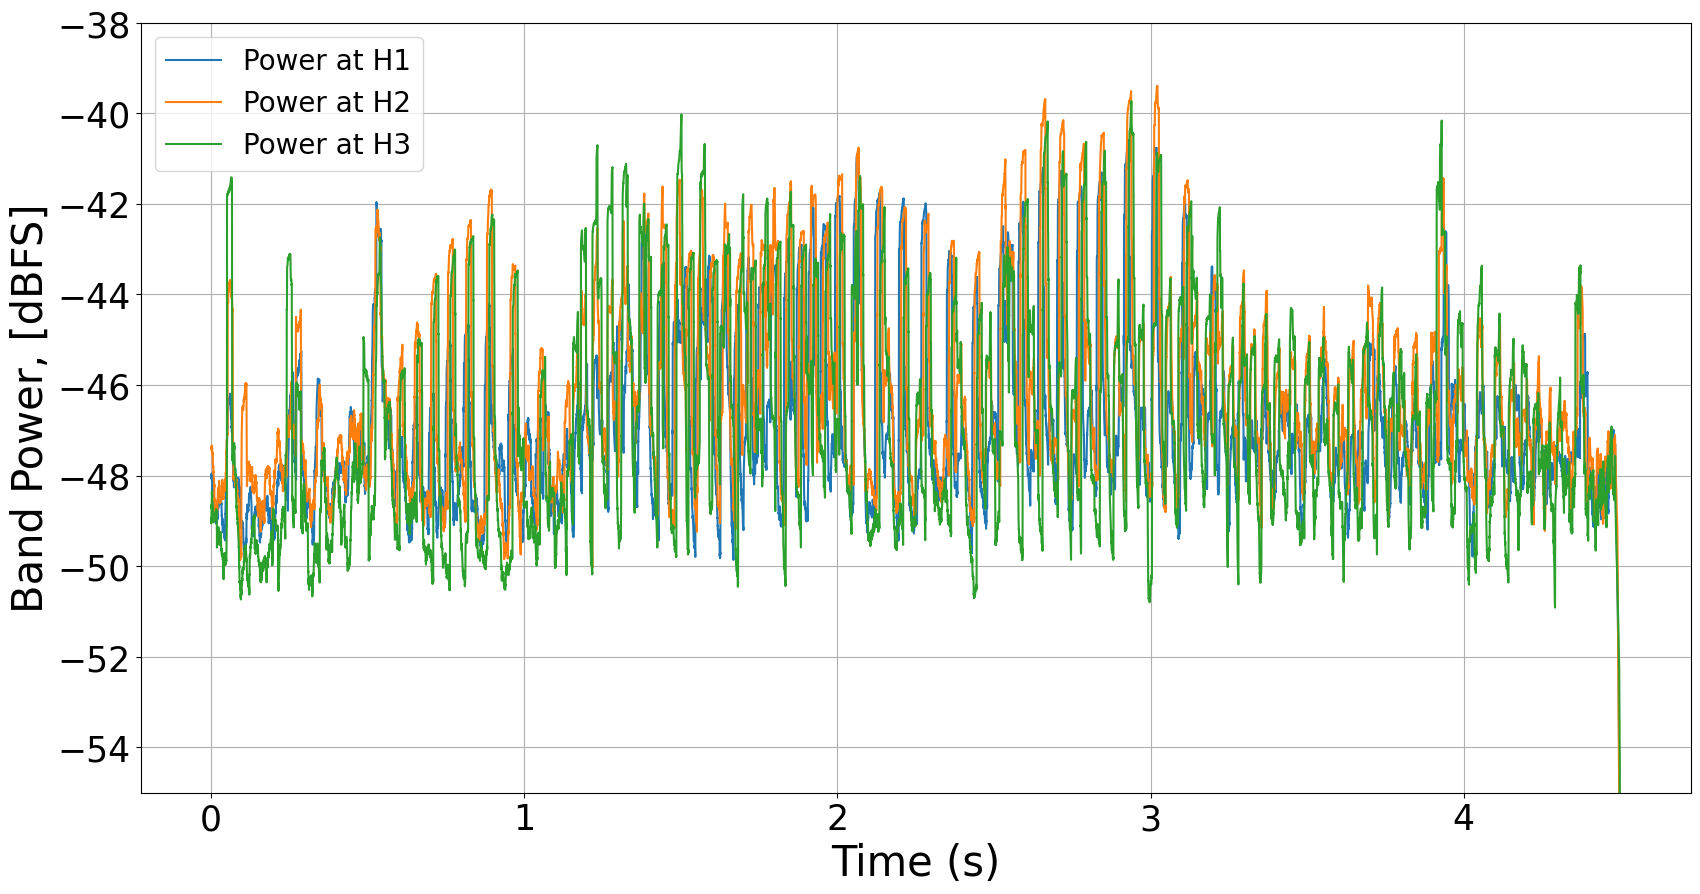

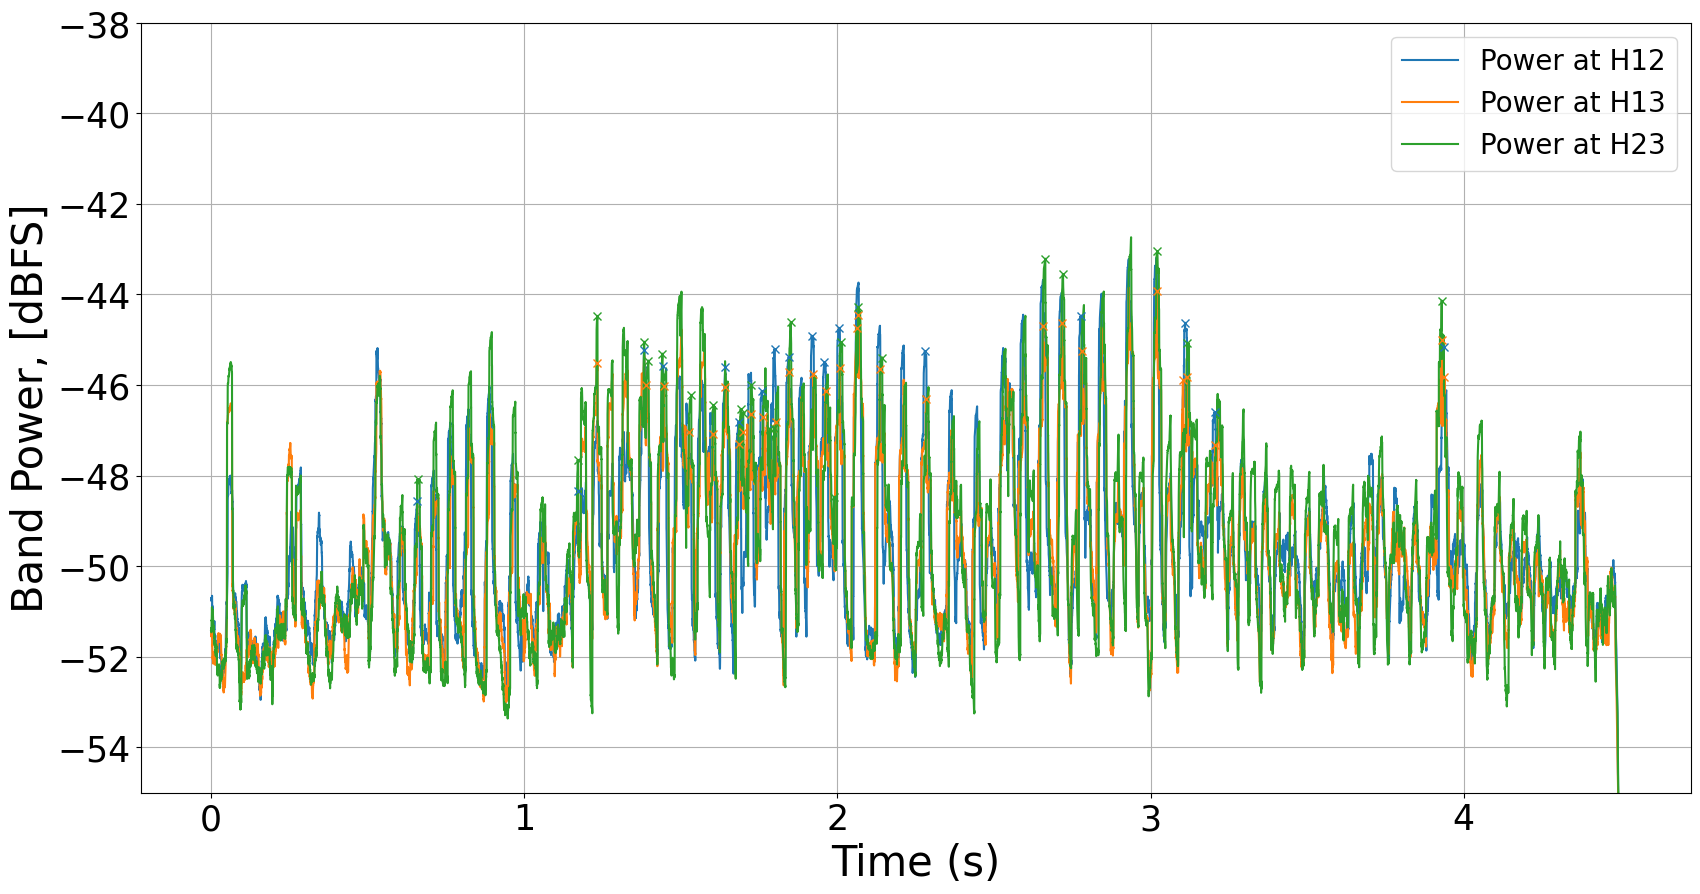

In [628]:
plt.figure()
xs = np.arange(0,len(h1_powers))
time = (win_size-noverlap)/fs

plt.plot(xs*time,(h1_powers), label = 'Power at H1')
plt.plot(xs*time,(h2_powers), label = 'Power at H2')
plt.plot(xs*time,(h3_powers), label = 'Power at H3')

plt.legend(fontsize = 20)
plt.xlabel('Time (s)', fontsize = 30)
plt.ylabel('Band Power, [dBFS]', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid()
plt.ylim([-55, -38])
# plt.xlim([300,500])

plt.figure()
plt.plot(xs*time,(h12_powers), label = 'Power at H12')
plt.plot(xs*time,(h13_powers), label = 'Power at H13')
plt.plot(xs*time,(h23_powers), label = 'Power at H23')
plt.plot(np.array(xs)[good_frame_inds_12]*time,np.array(h12_powers)[good_frame_inds_12], 'x', color='tab:blue')
plt.plot(np.array(xs)[good_frame_inds_13]*time,np.array(h13_powers)[good_frame_inds_13], 'x', color='tab:orange')
plt.plot(np.array(xs)[good_frame_inds_23]*time,np.array(h23_powers)[good_frame_inds_23], 'x', color='tab:green')


plt.legend(fontsize = 20)
plt.xlabel('Time (s)', fontsize = 30)
plt.ylabel('Band Power, [dBFS]', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid()
plt.ylim([-55, -38])
# plt.xlim([300,500])


<ipython-input-595-b11e4f769595>:1: RuntimeWarning: invalid value encountered in arcsin
  good_frame_angles_12 = np.arcsin(np.array(good_frame_delays_12)*c/d)
<ipython-input-595-b11e4f769595>:3: RuntimeWarning: invalid value encountered in arcsin
  good_frame_angles_23 = np.arcsin(np.array(good_frame_delays_23)*c/d)


67


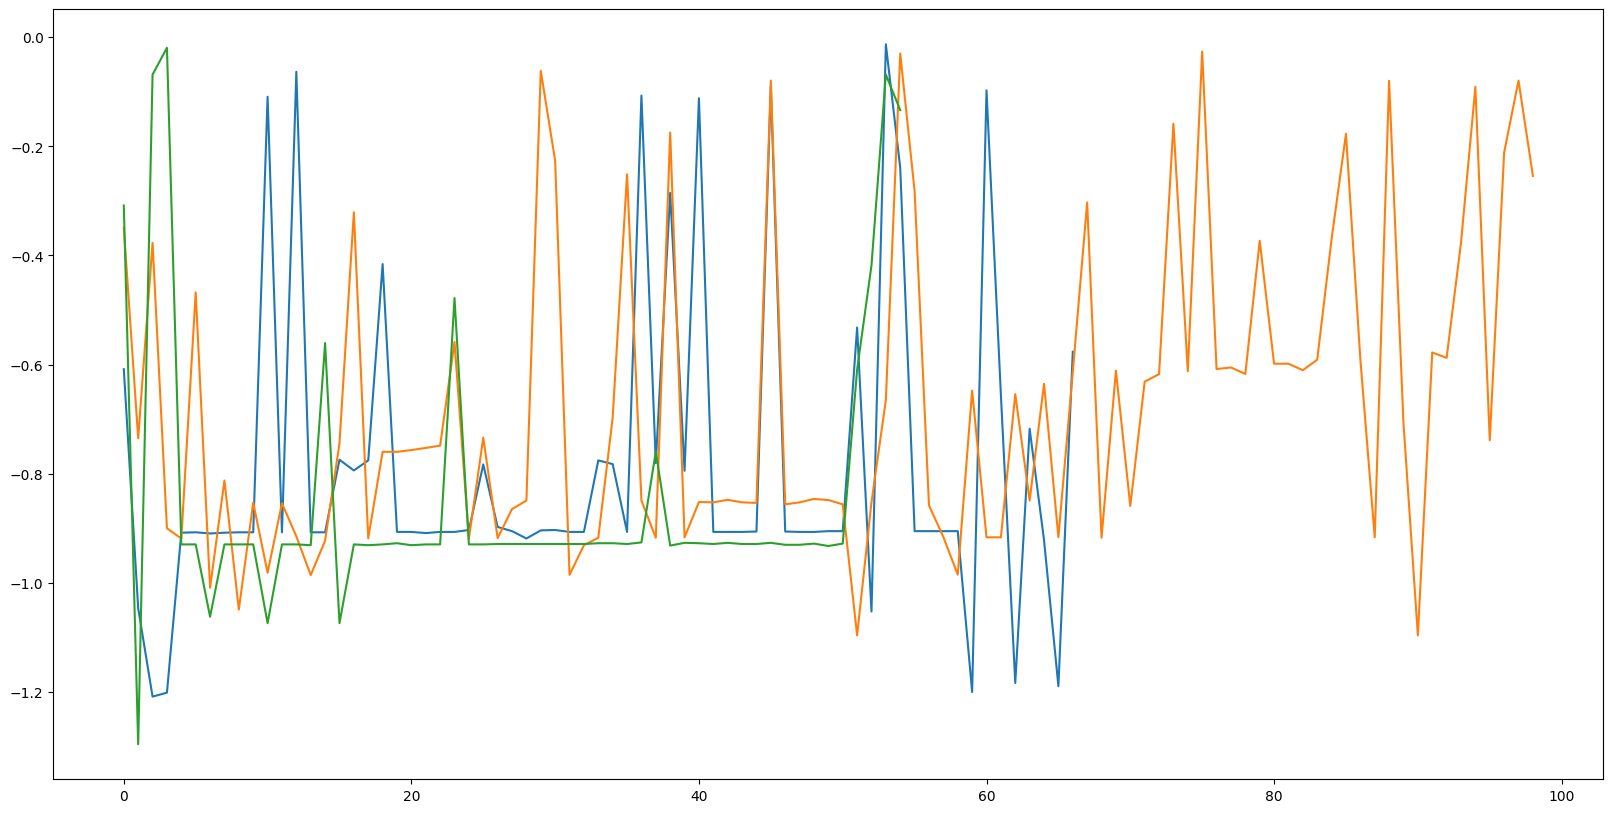

In [595]:
good_frame_angles_12 = np.arcsin(np.array(good_frame_delays_12)*c/d)
good_frame_angles_13 = np.arcsin(np.array(good_frame_delays_13)*c/(2*d))
good_frame_angles_23 = np.arcsin(np.array(good_frame_delays_23)*c/d)

good_frame_angles_12 = good_frame_angles_12[~np.isnan(good_frame_angles_12)]
good_frame_angles_13 = good_frame_angles_13[~np.isnan(good_frame_angles_13)]
good_frame_angles_23 = good_frame_angles_23[~np.isnan(good_frame_angles_23)]

# inds = np.arange(len(good_frame_angles_12))
# good_frame_angles_12 = np.interp(inds[np.isnan(good_frame_angles_12)], inds[~np.isnan(good_frame_angles_12)], np.array(good_frame_angles_12)[~np.isnan(good_frame_angles_12)])
# inds = np.arange(len(good_frame_delays_13))
# good_frame_angles_13 = np.interp(inds[np.isnan(good_frame_angles_13)], inds[~np.isnan(good_frame_angles_13)], np.array(good_frame_angles_13)[~np.isnan(good_frame_angles_13)])
# inds = np.arange(len(good_frame_angles_23))
# good_frame_angles_23 = np.interp(inds[np.isnan(good_frame_angles_23)], inds[~np.isnan(good_frame_angles_23)], np.array(good_frame_angles_23)[~np.isnan(good_frame_angles_23)])


plt.figure()
plt.plot(good_frame_angles_12)
plt.plot(good_frame_angles_13)
plt.plot(good_frame_angles_23)

print(len(good_frame_angles_12))


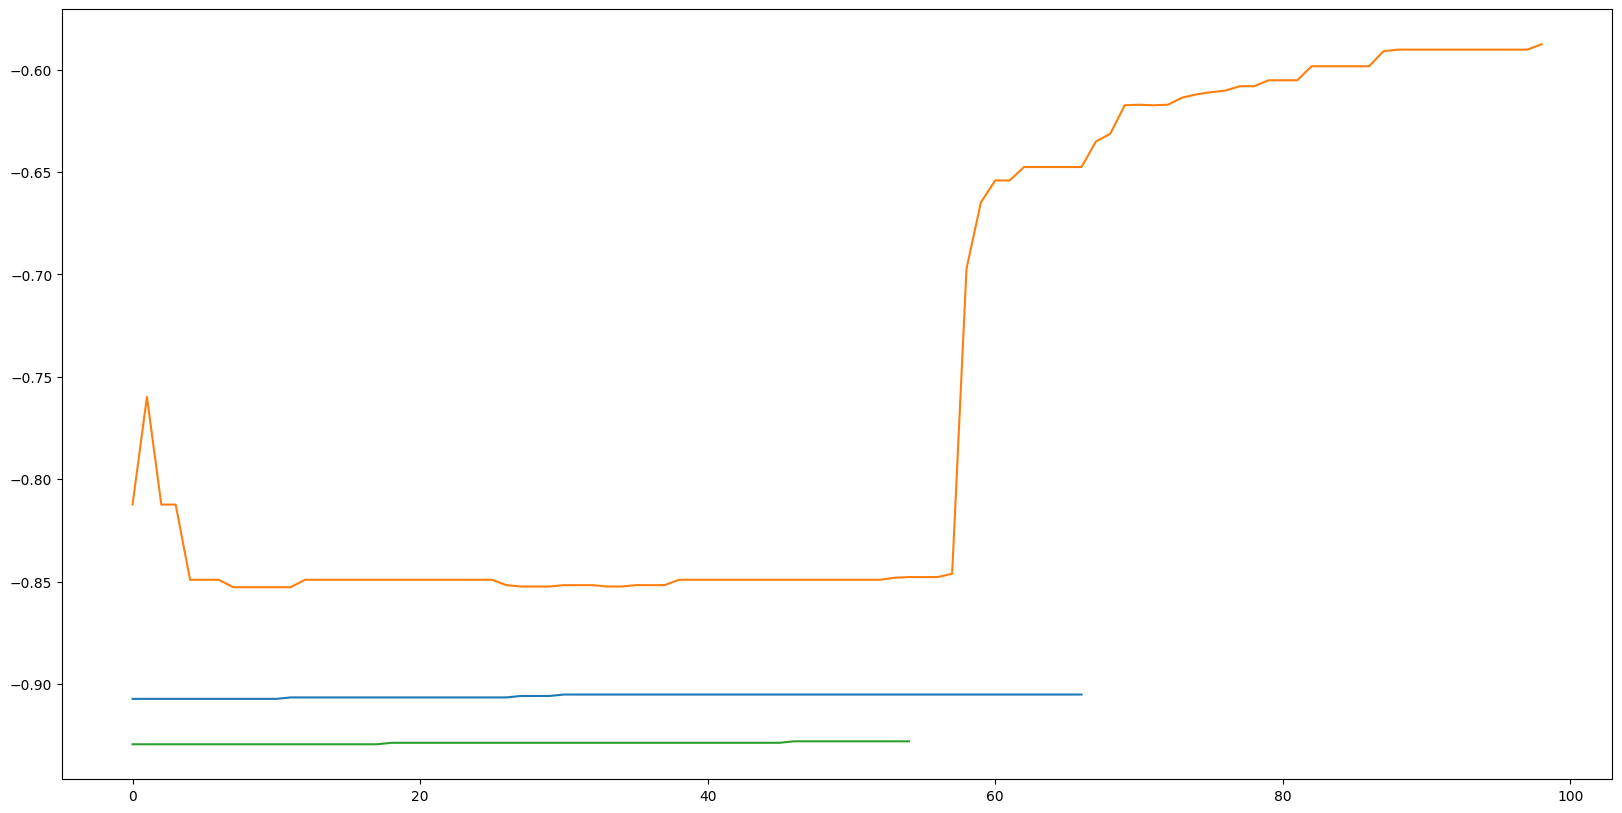

In [596]:
med_good_frame_angles_12 = scipy.ndimage.median_filter(good_frame_angles_12, size=50)
med_good_frame_angles_13 = scipy.ndimage.median_filter(good_frame_angles_13, size=50)
med_good_frame_angles_23 = scipy.ndimage.median_filter(good_frame_angles_23, size=50)

plt.figure()
plt.plot(med_good_frame_angles_12)
plt.plot(med_good_frame_angles_13)
plt.plot(med_good_frame_angles_23)

### Dolphin B

In [615]:
d = 14  # meters, separating hydrophones
c = 1520  # m/s, speed of sound in water
max_td = d/c

# win_size = 2500
noverlap = int(np.ceil(win_size*.99))

dB_peak_thresh_a = 18
dB_peak_thresh_b = 15
pk_distance = 5
click_cutoff = int(4.5 * fs)

In [616]:
# Dolphin B
h1_b = h1[click_cutoff:]
h2_b = h2[click_cutoff:]
h3_b = h3[click_cutoff:]

# Segment/buffer signals
h1_buff = buffer(h1_b, win_size, noverlap)
h2_buff = buffer(h2_b, win_size, noverlap)
h3_buff = buffer(h3_b, win_size, noverlap)

h1_powers = []
h2_powers = []
h3_powers = []

h12_powers = []
h13_powers = []
h23_powers = []

delays_12 = []
delays_13 = []
delays_23 = []

good_frame_delays_12 = []
good_frame_delays_13 = []
good_frame_delays_23 = []

dBThresh = -51

for i, (b1, b2, b3) in enumerate(zip(h1_buff, h2_buff, h3_buff)):
    h1_powers.append(20*np.log10(np.sqrt(np.mean(b1**2))))
    h2_powers.append(20*np.log10(np.sqrt(np.mean(b2**2))))
    h3_powers.append(20*np.log10(np.sqrt(np.mean(b3**2))))

    lag_12, cc_12 = gccphat(b1, b2)
    lag_13, cc_13 = gccphat(b1, b3)
    lag_23, cc_23 = gccphat(b2, b3)

    delays_12.append(lag_12)
    delays_13.append(lag_13)
    delays_23.append(lag_23)

    b12 = (b1+b2)/2
    b13 = (b1+b3)/2
    b23 = (b2+b3)/2

    e12 = 20*np.log10(np.sqrt(np.mean(b12**2)))
    e13 = 20*np.log10(np.sqrt(np.mean(b13**2)))
    e23 = 20*np.log10(np.sqrt(np.mean(b23**2)))
    # e12 = band_energy(fs, b12)
    # e13 = band_energy(fs, b13)
    # e23 = band_energy(fs, b23)

    h12_powers.append(e12)
    h13_powers.append(e13)
    h23_powers.append(e23)

    # if e12 > dBThresh:
    #     good_frame_delays_12.append(lag_12)
    # else:
    #     good_frame_delays_12.append(np.nan)

    # if e13 > dBThresh:
    #     good_frame_delays_13.append(lag_13)
    # else:
    #     good_frame_delays_13.append(np.nan)

    # if e23 > dBThresh:
    #     good_frame_delays_23.append(lag_23)
    # else:
    #     good_frame_delays_23.append(np.nan)

dB_peak_thresh_a = .5  # Dolphin A threshold
pk_distance = 1  # Distance between peaks, frames
pk_wlen = 100  # Samples to look around the peak
good_frame_inds_12, _ = scipy.signal.find_peaks(np.array(h12_powers), prominence=dB_peak_thresh_a, distance=pk_distance, wlen=pk_wlen)
good_frame_delays_12 = np.array(delays_12)[good_frame_inds_12]

good_frame_inds_13, _ = scipy.signal.find_peaks(np.array(h13_powers), prominence=dB_peak_thresh_a, distance=pk_distance, wlen=pk_wlen)
good_frame_delays_13 = np.array(delays_13)[good_frame_inds_13]

good_frame_inds_23, _ = scipy.signal.find_peaks(np.array(h23_powers), prominence=dB_peak_thresh_a, distance=pk_distance, wlen=pk_wlen)
good_frame_delays_23 = np.array(delays_23)[good_frame_inds_23]



<ipython-input-590-b1e382a3f10d>:8: RuntimeWarning: invalid value encountered in divide
  cc = np.fft.irfft(R/np.abs(R))


58.0
63
70
52


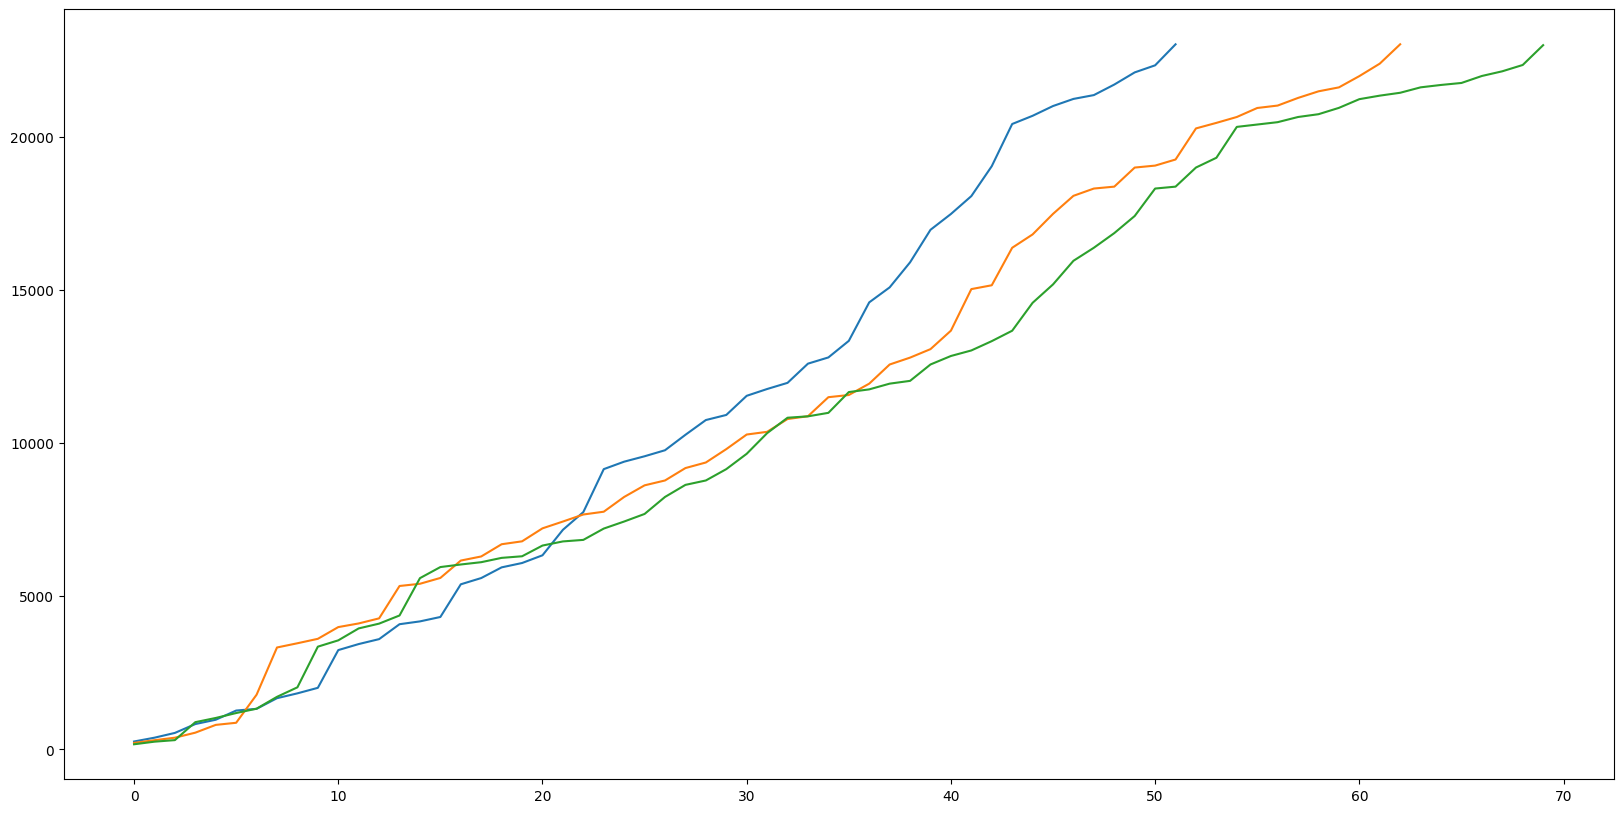

In [617]:
# Associate clicks on permutations of hydrophone pairs by removing unique high power frames

max_dist = np.ceil(max_td / ((win_size - noverlap) / fs))  # 7 m to either side, will need to be doubled for far comparison
print(max_dist)

mask_13 = np.zeros(len(good_frame_inds_13), dtype=bool)
mask_12 = np.zeros(len(good_frame_inds_12), dtype=bool)
mask_23 = np.zeros(len(good_frame_inds_23), dtype=bool)

for i, i_13 in enumerate(good_frame_inds_13):
  # if not (np.abs(good_frame_inds_12 - i_13) < max_dist).any() or not (np.abs(good_frame_inds_23 - i_13) < max_dist).any():
  #   good_frame_inds_13 = good_frame_inds_13[good_frame_inds_13 != i_13]
  mask_13[i] = (np.abs(good_frame_inds_12 - i_13) < max_dist).any() or \
                 (np.abs(good_frame_inds_23 - i_13) < max_dist).any()

for i, i_12 in enumerate(good_frame_inds_12):
  # if not (np.abs(good_frame_inds_13 - i_12) < max_dist).any() or not (np.abs(good_frame_inds_23 - i_12) < (2*max_dist)).any():
  #   good_frame_inds_12 = good_frame_inds_12[good_frame_inds_12 != i_12]
  mask_12[i] = (np.abs(good_frame_inds_13 - i_12) < max_dist).any() or \
                 (np.abs(good_frame_inds_23 - i_12) < (2 * max_dist)).any()

for i, i_23 in enumerate(good_frame_inds_23):
  # if not (np.abs(good_frame_inds_13 - i_23) < max_dist).any() or not (np.abs(good_frame_inds_12 - i_23) < (2*max_dist)).any():
    # good_frame_inds_23 = good_frame_inds_23[good_frame_inds_23 != i_23]
  mask_23[i] = (np.abs(good_frame_inds_13 - i_23) < max_dist).any() or \
                 (np.abs(good_frame_inds_12 - i_23) < (2 * max_dist)).any()


good_frame_inds_13 = good_frame_inds_13[mask_13]
good_frame_inds_12 = good_frame_inds_12[mask_12]
good_frame_inds_23 = good_frame_inds_23[mask_23]

print(len(good_frame_inds_13))
print(len(good_frame_inds_23))
print(len(good_frame_inds_12))

plt.figure()
plt.plot(good_frame_inds_12)
plt.plot(good_frame_inds_13)
plt.plot(good_frame_inds_23)


(-55.0, -45.0)

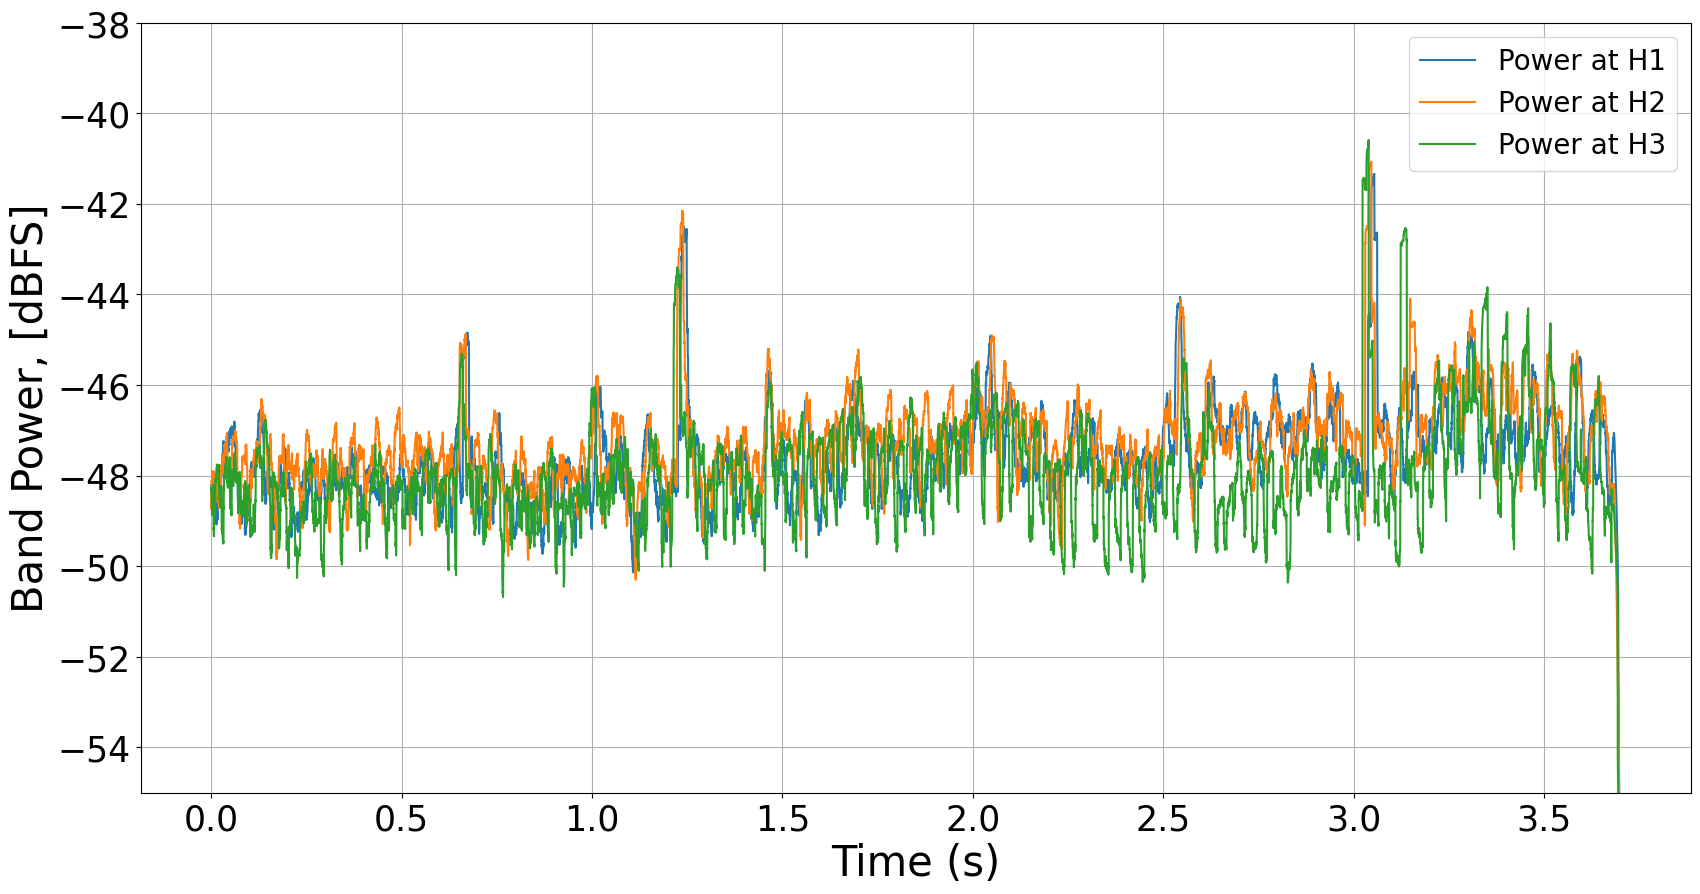

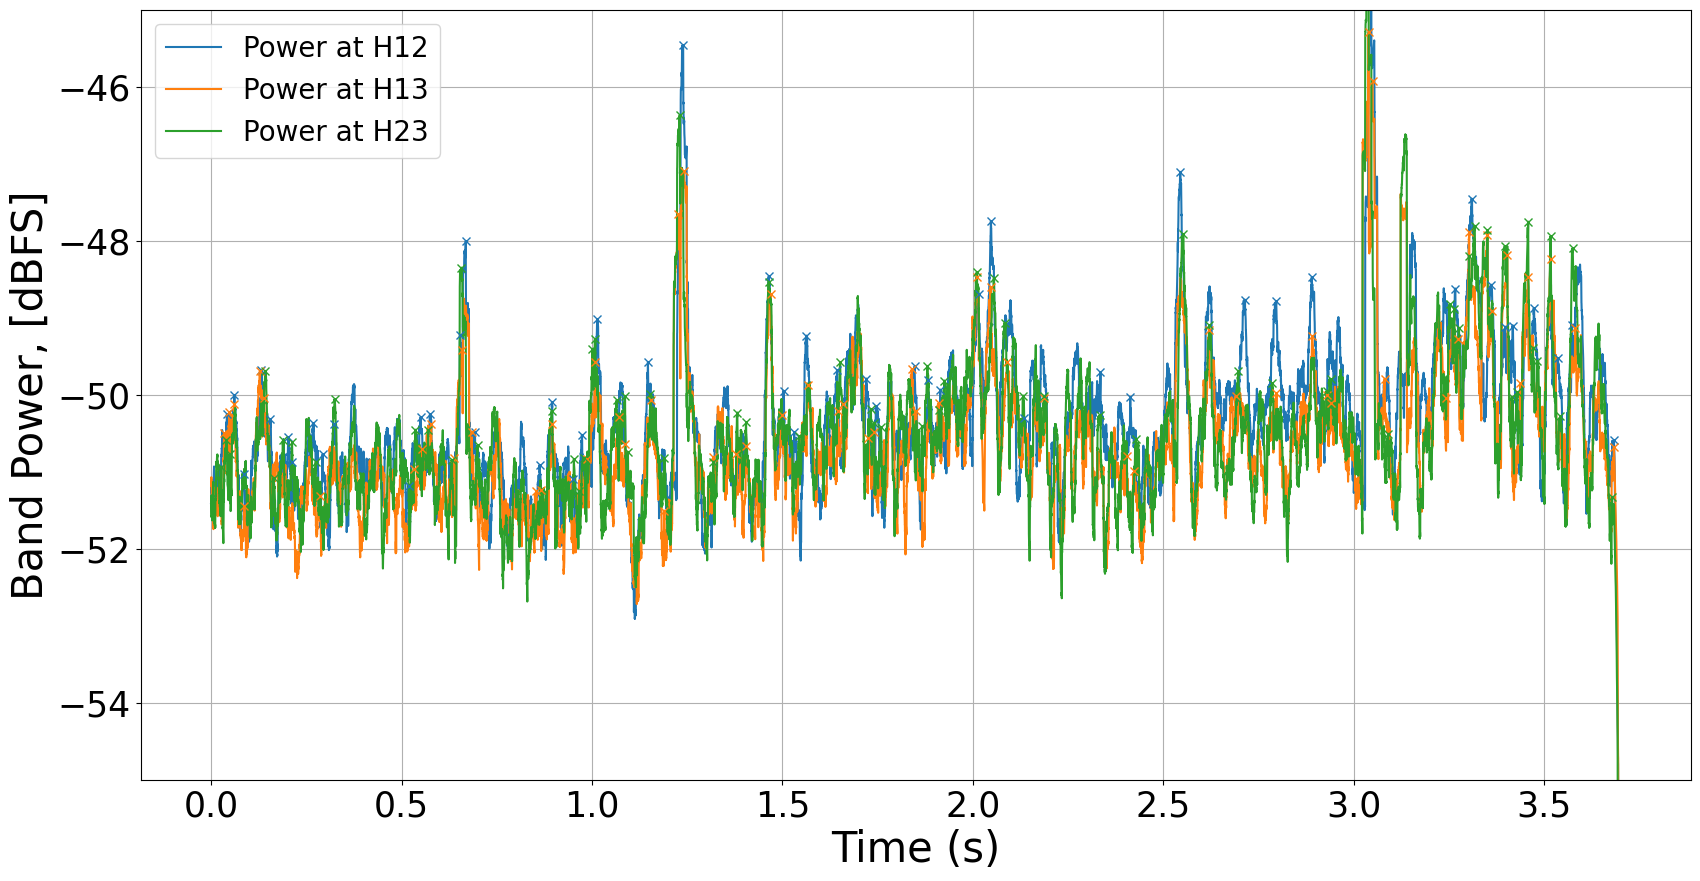

In [620]:
plt.figure()
xs = np.arange(0,len(h1_powers))
time = (win_size-noverlap)/fs

plt.plot(xs*time,(h1_powers), label = 'Power at H1')
plt.plot(xs*time,(h2_powers), label = 'Power at H2')
plt.plot(xs*time,(h3_powers), label = 'Power at H3')

plt.legend(fontsize = 20)
plt.xlabel('Time (s)', fontsize = 30)
plt.ylabel('Band Power, [dBFS]', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid()
plt.ylim([-55, -38])
# plt.xlim([300,500])

plt.figure()
plt.plot(xs*time,(h12_powers), label = 'Power at H12')
plt.plot(xs*time,(h13_powers), label = 'Power at H13')
plt.plot(xs*time,(h23_powers), label = 'Power at H23')
plt.plot(np.array(xs)[good_frame_inds_12]*time,np.array(h12_powers)[good_frame_inds_12], 'x', color='tab:blue')
plt.plot(np.array(xs)[good_frame_inds_13]*time,np.array(h13_powers)[good_frame_inds_13], 'x', color='tab:orange')
plt.plot(np.array(xs)[good_frame_inds_23]*time,np.array(h23_powers)[good_frame_inds_23], 'x', color='tab:green')

plt.legend(fontsize = 20)
plt.xlabel('Time (s)', fontsize = 30)
plt.ylabel('Band Power, [dBFS]', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid()
plt.ylim([-55, -45])
# plt.xlim([300,500])

<ipython-input-607-e3ad97377899>:1: RuntimeWarning: invalid value encountered in arcsin
  good_frame_angles_12 = np.arcsin(np.array(good_frame_delays_12)*c/d)
<ipython-input-607-e3ad97377899>:3: RuntimeWarning: invalid value encountered in arcsin
  good_frame_angles_23 = np.arcsin(np.array(good_frame_delays_23)*c/d)


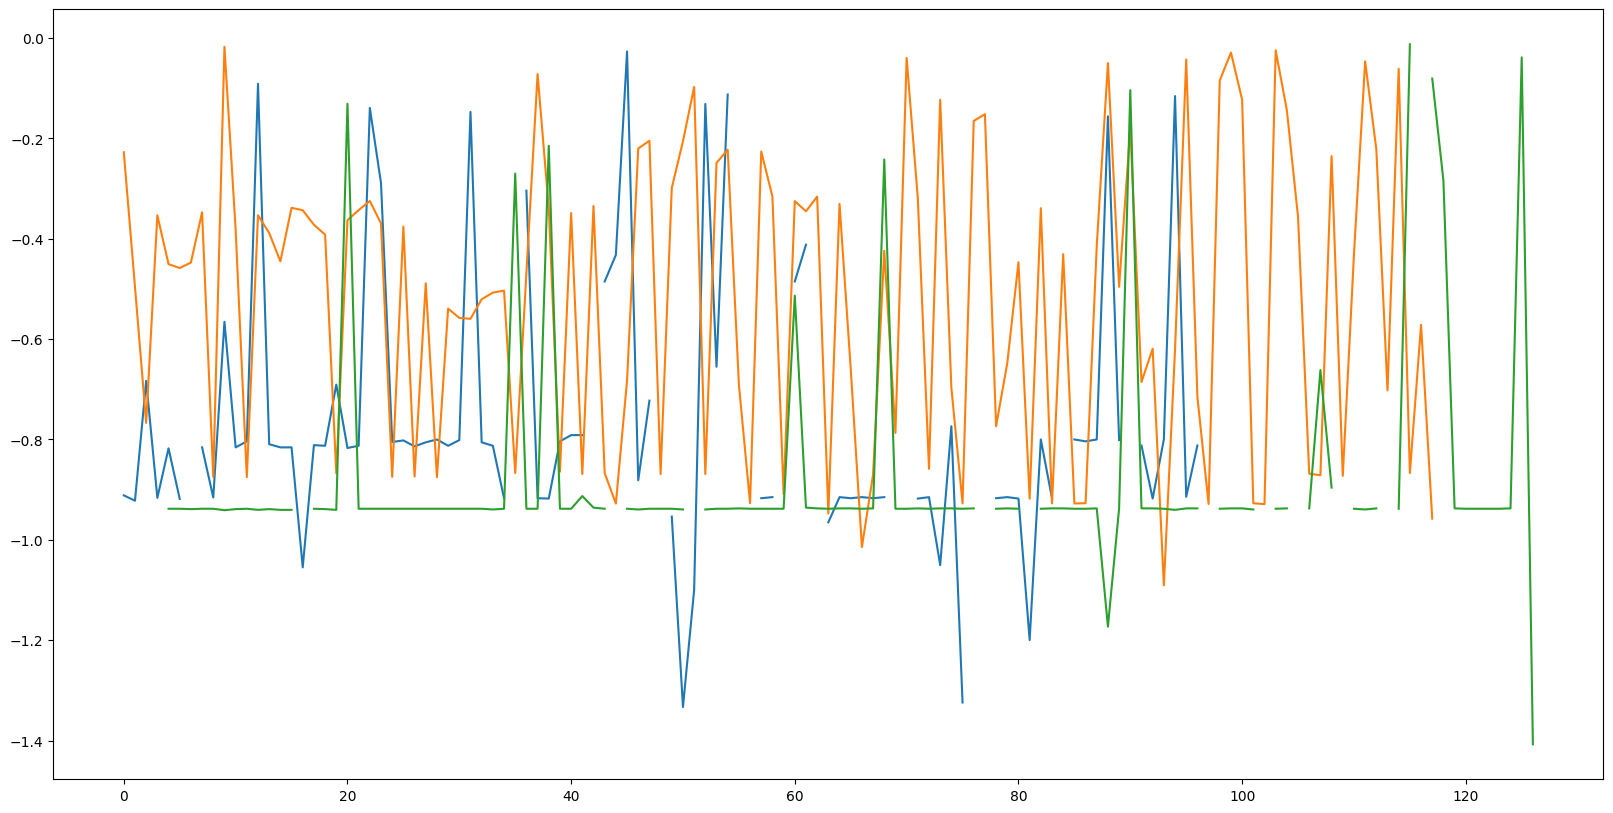

In [607]:
good_frame_angles_12 = np.arcsin(np.array(good_frame_delays_12)*c/d)
good_frame_angles_13 = np.arcsin(np.array(good_frame_delays_13)*c/(2*d))
good_frame_angles_23 = np.arcsin(np.array(good_frame_delays_23)*c/d)

# inds = np.arange(len(good_frame_angles_12))
# good_frame_angles_12 = np.interp(inds[np.isnan(good_frame_angles_12)], inds[~np.isnan(good_frame_angles_12)], np.array(good_frame_angles_12)[~np.isnan(good_frame_angles_12)])
# inds = np.arange(len(good_frame_delays_13))
# good_frame_angles_13 = np.interp(inds[np.isnan(good_frame_angles_13)], inds[~np.isnan(good_frame_angles_13)], np.array(good_frame_angles_13)[~np.isnan(good_frame_angles_13)])
# inds = np.arange(len(good_frame_angles_23))
# good_frame_angles_23 = np.interp(inds[np.isnan(good_frame_angles_23)], inds[~np.isnan(good_frame_angles_23)], np.array(good_frame_angles_23)[~np.isnan(good_frame_angles_23)])


plt.figure()
plt.plot(good_frame_angles_12)
plt.plot(good_frame_angles_13)
plt.plot(good_frame_angles_23)


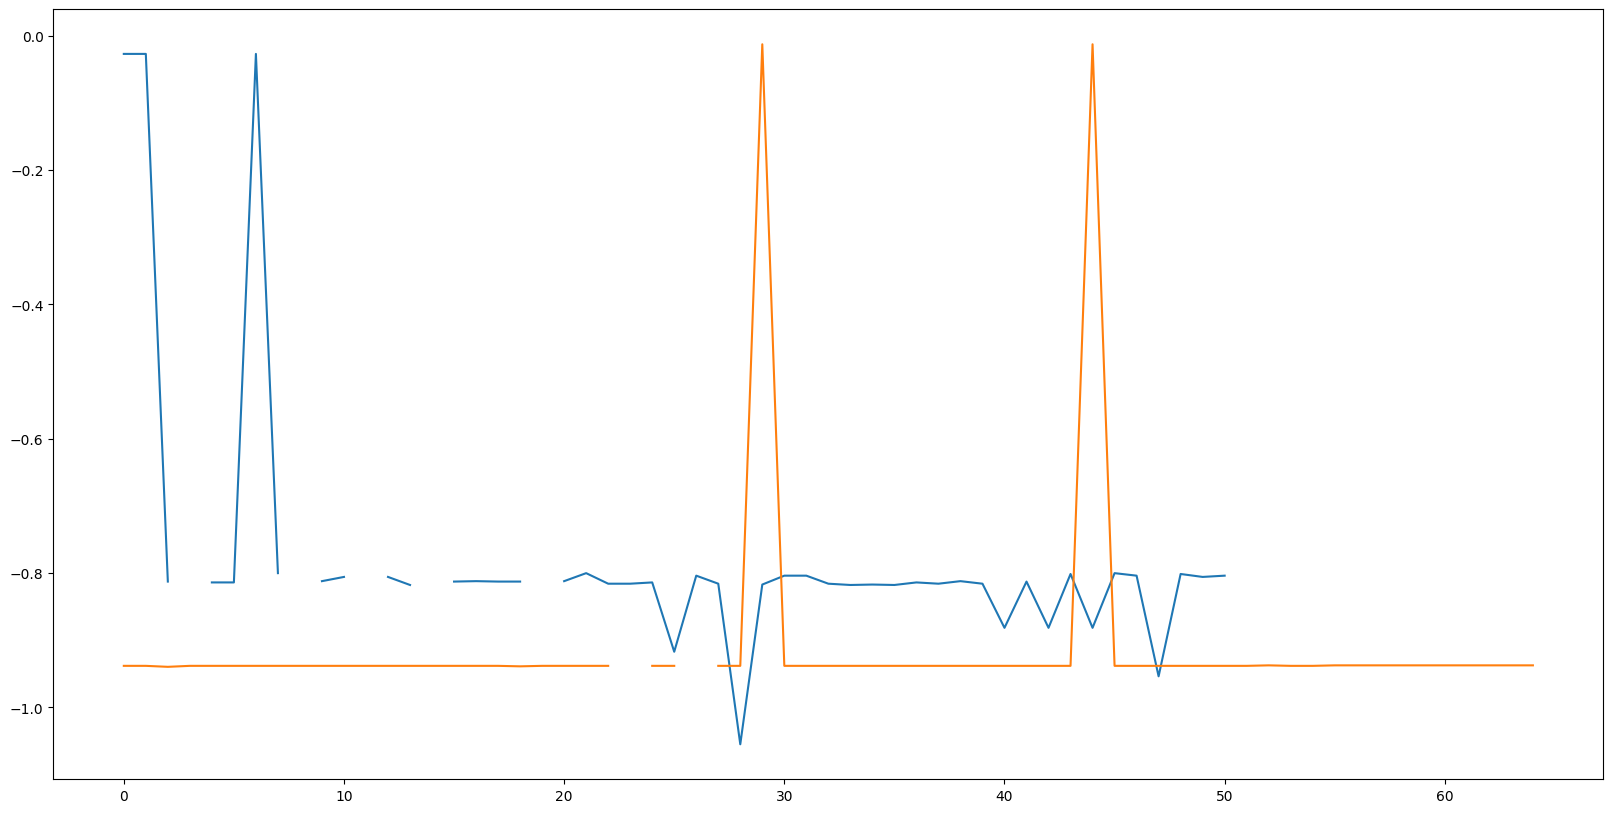

In [602]:
med_good_frame_angles_12 = scipy.ndimage.median_filter(good_frame_angles_12, size=75)
med_good_frame_angles_13 = scipy.ndimage.median_filter(good_frame_angles_13, size=75)
med_good_frame_angles_23 = scipy.ndimage.median_filter(good_frame_angles_23, size=75)

plt.figure()
plt.plot(med_good_frame_angles_12)
# plt.plot(med_good_frame_angles_13)
plt.plot(med_good_frame_angles_23)